# Telangana PDS – Final Clustering Model

Comprehensive modeling notebook including:
- Column cleaning
- Shop-level aggregation
- Feature engineering
- PCA visualization
- KMeans (Elbow + Silhouette)
- HDBSCAN clustering
- Cluster profiling


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import hdbscan

sns.set(style='whitegrid')

master_df = pd.read_csv('master_pds_dataset.csv')
master_df.shape

(499494, 56)

# 1. Drop Unnecessary Columns

In [2]:
cols_to_drop = [
    'noOfTrans','totalRcs','totalUnits','totalUnitsNfsa',
    'riceAfsc','riceFsc','riceAap','wheat','sugar','rgdal','kerosene','salt',
    'officeCode','officeName','address','latitude','longitude','month','year'
]

cols_to_drop = [c for c in cols_to_drop if c in master_df.columns]
df = master_df.drop(columns=cols_to_drop)
df.shape

(499494, 37)

# 2. Shop-Level Aggregation

In [3]:
shop_df = df.groupby(['distCode','shopNo'])[
    ['utilization_ratio','portability_ratio','rice_wheat_ratio','yearly_transaction_volatility']
].mean().reset_index()

shop_df.shape

(17491, 6)

# 3. Feature Engineering & Cleaning

In [4]:
shop_df['log_volatility'] = np.log1p(shop_df['yearly_transaction_volatility'])
shop_df['log_rice_wheat'] = np.log1p(shop_df['rice_wheat_ratio'])

features = ['utilization_ratio','portability_ratio','log_volatility','log_rice_wheat']

X = shop_df[features].copy()

X.replace([np.inf,-np.inf],np.nan,inplace=True)
X['log_volatility'] = X['log_volatility'].fillna(0)

for col in ['utilization_ratio','portability_ratio','log_rice_wheat']:
    X[col] = X[col].fillna(X[col].median())

X.isnull().sum()

utilization_ratio    0
portability_ratio    0
log_volatility       0
log_rice_wheat       0
dtype: int64

# 4. Scaling

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[ 0.12279445, -0.89971801,  1.09626606,  0.82821638],
       [ 0.3007776 , -0.84213884,  0.44030769,  0.47115005],
       [ 0.44040327, -0.76948296, -0.29820779,  0.06497381],
       [ 0.3578791 , -0.90276115,  0.05050681,  0.27403816],
       [ 0.55041119, -0.91672401,  1.01220886,  0.91047913]])

# 5. PCA Visualization

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print('Explained Variance:', pca.explained_variance_ratio_)

Explained Variance: [0.42592345 0.27607044]


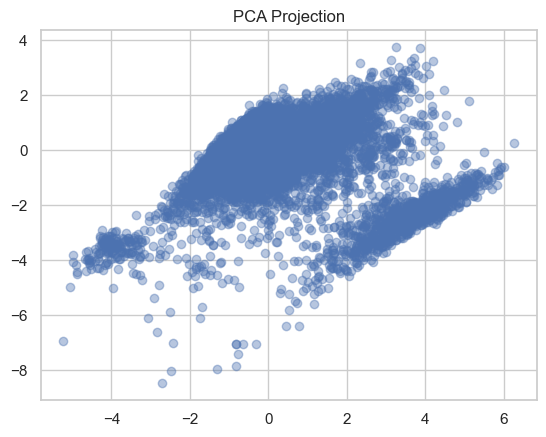

In [7]:
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.4)
plt.title('PCA Projection')
plt.show()

# 6. KMeans Clustering

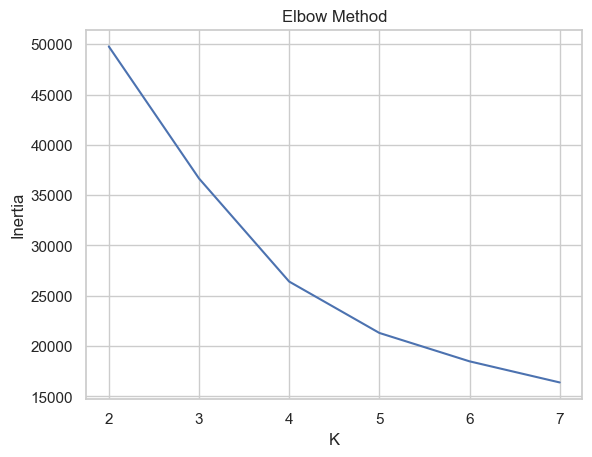

In [8]:
inertia = []
for k in range(2,8):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure()
plt.plot(range(2,8), inertia)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
labels_km = kmeans.fit_predict(X_scaled)

print('KMeans Silhouette:', silhouette_score(X_scaled, labels_km))

KMeans Silhouette: 0.4248185914392132


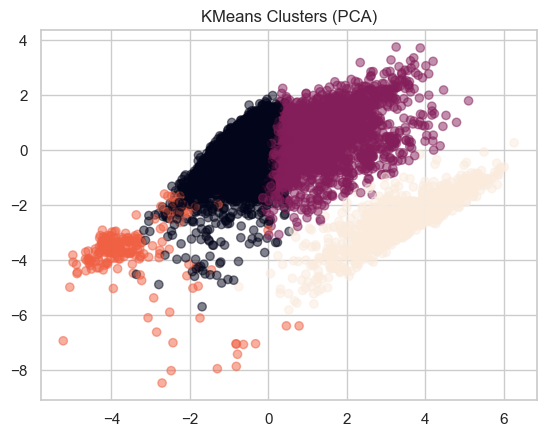

In [10]:
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_km, alpha=0.5)
plt.title('KMeans Clusters (PCA)')
plt.show()

# 7. HDBSCAN Clustering

In [11]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
labels_hdb = clusterer.fit_predict(X_scaled)

noise_count = np.sum(labels_hdb == -1)
print('HDBSCAN Clusters:', len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0))
print('Noise %:', noise_count/len(labels_hdb)*100)

HDBSCAN Clusters: 3
Noise %: 2.6585100909038935


In [12]:
core_mask = labels_hdb != -1
print('HDBSCAN Silhouette (core only):', silhouette_score(X_scaled[core_mask], labels_hdb[core_mask]))

HDBSCAN Silhouette (core only): 0.6637284465056934


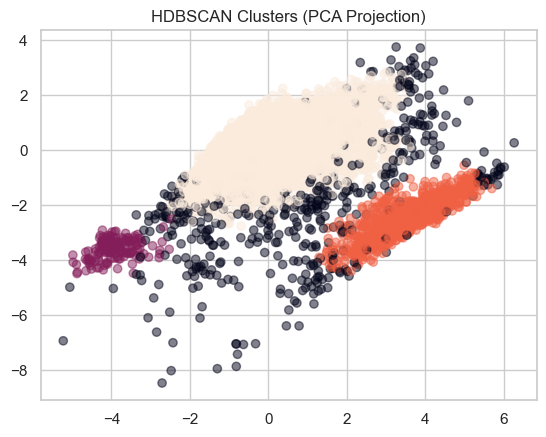

In [13]:
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_hdb, alpha=0.5)
plt.title('HDBSCAN Clusters (PCA Projection)')
plt.show()

KMeans identified four interpretable behavioral personas (Silhouette = 0.42).
HDBSCAN identified three dominant density-based behavioral cores with only 2% noise, indicating strong natural structure in the data.
The fourth KMeans cluster likely represents a sub-segmentation of a broader dense behavioral region.

# 8. Cluster Profiling

## KMeans

In [20]:
# ---------- KMEANS PROFILING TABLE ----------

kmeans_profile = shop_df.copy()
kmeans_profile["cluster_kmeans"] = labels_km

summary_km = (
    kmeans_profile
    .groupby("cluster_kmeans")
    .agg({
        "utilization_ratio": "mean",
        "portability_ratio": "mean",
        "log_volatility": "mean",
        "log_rice_wheat": "mean",
        "shopNo": "count"
    })
    .rename(columns={"shopNo": "shop_count"})
)

summary_km["percentage"] = (
    summary_km["shop_count"] / summary_km["shop_count"].sum() * 100
)

summary_km = summary_km.round(3)

In [21]:
persona_map = {
    0: "Stable Rural Mainstream",
    1: "Urban Mobility-Driven",
    2: "Low-Variability Controlled",
    3: "High-Portability Transit Hubs"
}

summary_km["persona"] = summary_km.index.map(persona_map)

summary_km = summary_km[
    ["persona","shop_count","percentage",
     "utilization_ratio","portability_ratio",
     "log_volatility","log_rice_wheat"]
]

summary_km

,persona,shop_count,percentage,utilization_ratio,portability_ratio,log_volatility,log_rice_wheat
cluster_kmeans,,,,,,,
0,Stable Rural Mainstream,11975,68.464,0.781,0.133,7.152,8.762
1,Urban Mobility-Driven,4365,24.956,0.960,0.583,7.642,9.072
2,Low-Variability Controlled,204,1.166,0.806,0.233,2.702,8.303
3,High-Portability Transit Hubs,947,5.414,0.974,0.779,8.071,2.249


## HDBSCAN

In [22]:
# ---------- HDBSCAN PROFILING ----------

shop_df["cluster_hdb"] = labels_hdb

# Remove noise (-1)
hdb_profile = shop_df[shop_df["cluster_hdb"] != -1]

summary_hdb = (
    hdb_profile
    .groupby("cluster_hdb")
    .agg({
        "utilization_ratio": "mean",
        "portability_ratio": "mean",
        "log_volatility": "mean",
        "log_rice_wheat": "mean",
        "shopNo": "count"
    })
    .rename(columns={"shopNo": "shop_count"})
)

summary_hdb["percentage"] = (
    summary_hdb["shop_count"] / len(shop_df) * 100
)

summary_hdb = summary_hdb.round(3)

In [19]:
hdb_persona_map = {
    0: "Stable Core Shops",
    1: "Urban High-Activity Core",
    2: "Transit Mobility Core"
}

summary_hdb["persona"] = summary_hdb.index.map(hdb_persona_map)

summary_hdb = summary_hdb[
    ["persona","shop_count","percentage",
     "utilization_ratio","portability_ratio",
     "log_volatility","log_rice_wheat"]
]

summary_hdb

,persona,shop_count,percentage,utilization_ratio,portability_ratio,log_volatility,log_rice_wheat
cluster_hdb,,,,,,,
0,Stable Core Shops,153,0.875,0.833,0.144,1.104,8.867
1,Urban High-Activity Core,824,4.711,0.997,0.777,8.163,2.170
2,Transit Mobility Core,16049,91.756,0.829,0.246,7.291,8.870
